# Basics of mobile robotics project - The Thytanic Navigation (2024)

## 1. Introduction & Context

| **Contributors**         | **Sciper**  | **Role**             | **Studies**                                                                   |
|---------------------------|-------------|-----------------------|---------------------------------------------------------------------------  |
| **Alessio Desogus**       | 301705      | `Local Navigation`      | Bachelor and Master in Mechanical Engineering                              |
|   **Antoine Bachmann**    |  336641     | `Global navigation`      | Bachelor and Master in Computer Science                                   |
|**Ramon Heeb**             |   396213    | `Vision`                | Bachelor in Computer Science, Master in Robotics                           |
| **Adélaïde Pinel**        |330753       |  `Kalman Filtering`                     |  Bachelor and Master in Mechanical Engineering             |

Date of deliverable: 05.12.2024  

Our main sources were: 
- .
- .

### Project Description

This project involves guiding the **Thytanic** from its starting position to its destination in an efficient manner using `Global Navigation`. Along the way, the Thytanic must avoid appearing obstacles by employing `Local Navigation`. Additionally, the position of the Thytanic is estimated using a `Kalman Filter`. Finally, a stationary camera is positioned above the map to provide `Vision` information for the system’s navigation modules.

Imagine the following scenario: the Thytanic is navigating in the vast ocean (**blue background**) and is seeking to reach land (**white area**) safely while avoiding dangerous icebergs (**local obstacles**). At the same time, it must avoid colliding with **black zones** representing dangerous land masses. Its goal is to navigate the shortest, most energy-efficient route to safety.


![Local Navigation Algorithm](img/thytanic.png)

- Image reference background: https://www.freepik.com/premium-ai-image/iceberg-water-with-icebergs-background_55113664.htm
- Image reference thymio: https://edu.ge.ch/site/desrobotsenclasse/wp-content/uploads/sites/269/2015/02/front.jpg


## 2. Initialization

We start by importing the necessary modules, functions and basic libraries:  
- `local_navigation_and_control_all` for the local navigation and overall control of the Thytanic  
- `vision` for computer vision functions  
- `global_navigation` for global path planning functions  
- `kalman_filtering_all` for Kalman filter functions

In [19]:
from local_navigation_and_control import ThytanicController, ThytanicState
from vision import get_current_state, init_cam
from global_navigation import downsamplingprep, downsampling, pathfinder
from kalman_filtering import kalman_filter
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

Next, we initialize the `ThytanicController`: 

In [20]:
thytanic = ThytanicController()

## 3. Vision

For Vision we chose to adapt the strategy of color based thresholding to create the map of our environment and get the position and orientation of the thymio. 
For the thresholding you can see the allowed ranges of values for obstacles, targets, and the front and back of the thymio in the HSV color space. It is important that all objects have at least one value where the range is completely distinct from all the other objects. This allows for an unambiguous assignemnt of a pixel to an object.  

After that *the get_current_state* function is called. It returns a 2d numpy array that contains numbers indicating the object that each pixel belongs to. Additionally the position of the thymio in this pixel matrix and its orientation is returned.
The function works in the following way:

- First a picture is taken by the supplied camera. The camera can be obtained by the *init_cam* function. For taking the picture and all of the following operations the library opencv is used.

- When we have obtained the image we scale it down in order to reduce the computation time of the subsequent operations. The *pyrDown* from opencv is used to achieve this. The function works by combining the values of 4 adjacent pixels and merging them into one pixel in the scaled down image. Applying this function twice results in a new image of size 160 to 120. Going any lower produced unsatisfactory results in the orientation estimation of the Thymio as not enough pixels were available for an accurate result. Documentation of the function can be found here: https://docs.opencv.org/4.x/d4/d1f/tutorial_pyramids.html

- Next, the image is transformed to the HSV color space. The HSV space is more robust to lighting changes then the RGB color space. In the RGB color space changes in brightness result in changes for all 3 values. In HSV a brightness changes ideally only affects the V value. This in turn allows for an easier color separation even under different lighting conditions. In fact we used RGB in a previous iteration of this algorithm and never achieved a stable object segmentation with it. To learn about the HSV color space, the following page was really helpful: https://ch.mathworks.com/help/images/understanding-color-spaces-and-color-space-conversion.html

- Then the actual thresholding is performed. We check for each pixel in the image, if all of its h, s and v values lie in one of the hsv ranges provided as arguments. If they do, we know that the object that the range corresponds to must be located at the location of that pixel.  
    

In [ ]:
#create a 4-channel map of the environment
cam = init_cam()
obstacle_range=[np.array([0, 130, 0]), np.array([160, 240, 140])]
target_range=[np.array([0, 30, 235]), np.array([255, 130, 256])]
th_front_range=[np.array([0, 160, 253]), np.array([15, 250, 256])]
th_back_range=[np.array([16, 130, 141]), np.array([40, 250, 252])]
img, _, _ = get_current_state(
    cam=cam,
    obstacle_range=obstacle_range,
    target_range=target_range,
    th_front_range=th_front_range,
    th_back_range=th_back_range,
)

## 4. Global Navigation


For global navigation, we have two distinct phases: image postprocessing and pathfinding.

The first turns the already cleaned and processed image into an obstacle position binary 2d array, a thymio position, and an objective position.

This is done using significant downsampling, as the thymio has limited precision in its movements and as such very small pixels would not bring significant utility while making all processing operations much more expensive.

- The 2d array is binary and only features obstacles and free spaces, this is for ease of morphological operations, as the other two data points can be summed up to a single point which is easier to keep out of array for programming purposes, especially testing.

- The thymio position on the image, and thus its equivalent in the output array uses the thimyo's pixels average position, this is due to ease of implementation and practical functionality, more complex solutions were not needed, so we went no further.
  
- The goal position is as the thymio position.


The 2d array is then dilated morphologically and its pixels fused to reach the desired size, the threshold parameter determines what minimum proportion of a superpixel should contain obstacles for the superpixel to have a value of 1.

Pathfinding is conceptually very simple, thanks to the limited size of our 2darray, dijkstra becomes computationally viable. As our system has no cul-de-sacs or significant detours, euclidean distance from the objective is an excellent heuristic which allows us to implement an [A*](https://dl.acm.org/doi/10.1145/3828.3830) algorithm that provides a very significant improvement in computation time.

Here we used the square of the euclidean distance once again for computational reasons, this gave extreme weight to the heuristic compared to the path length but as long as the obstacles remain cul-de-sac free this is a massive computational gain over djikstra.



[]

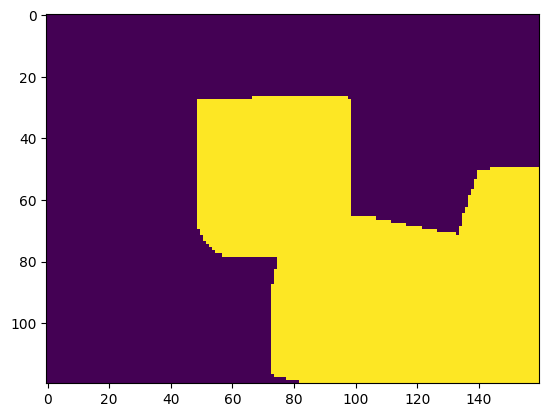

In [ ]:
endsize = [120, 160]

#this line generates the original enposition, thymio position, and the obstacle channel
thymiopos, endpos, obstacleimage = downsamplingprep(img, endsize, 1, 1)

#this line turns obstacleimage into its downsampled version with enlarged obstacles
preppedimage = downsampling(obstacleimage, endsize, 24, 0.2)


plt.imshow(preppedimage)
plt.plot()

The three addition lines are here for some data visualization, the colours let us see what nodes were taken as path points, explored, and unexplored but considered by the algorithm.

[]

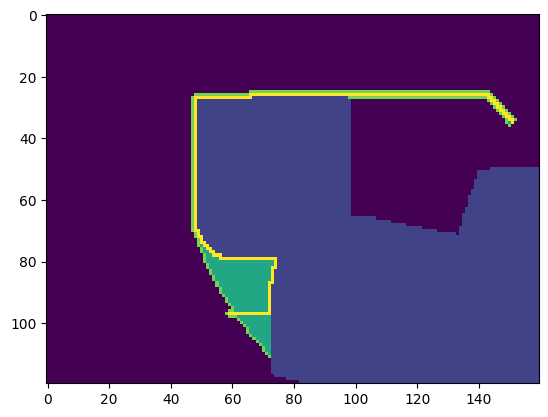

In [23]:
path, exploredpoints, unexploredpoints = pathfinder(thymiopos, endpos, preppedimage)

testimage = preppedimage.copy()

for k in path:
    testimage[k[0], k[1]] += 2
    
for k in exploredpoints:
    testimage[k[0], k[1]] += 3

for k in unexploredpoints:
    testimage[k[0], k[1]] += 4


plt.imshow(testimage)
plt.plot()

## 5. Kalman Filter

The Kalman filter function is implemented in **`kalman_filtering.py`**, following the steps outlined in the lecture slides of **Lecture 8** in the course *Basics of Mobile Robotics* by Pr. Mondada. 

We used the Kalman filter to estimate the position of the robot, assuming the noise covariance is Gaussian. This method "fuses" the information from the sensors in a way that minimizes the error covariance during computation.


### System Dynamics

Our system dynamics are modeled as:

1. **State evolution**:
   $$
   x^+ = Ax + w
   $$

2. **Measurement equation**:
   $$
   y = Cx + v
   $$

Where:  
- The state vector is defined as:  
  $$
  x = [x_{\text{pos}}, v_x, y_{\text{pos}}, v_y, \theta, \omega]^T
  $$
- $ w $ is the stochastic state perturbation, with a covariance matrix $ Q $:  
$$
Q = 
\begin{bmatrix}
\text{var}_x & 0 & 0 & 0 & 0 & 0 \\
0 & \text{var}_\text{vel} & 0 & 0 & 0 & 0 \\
0 & 0 & \text{var}_y & 0 & 0 & 0 \\
0 & 0 & 0 & \text{var}_\text{vel} & 0 & 0 \\
0 & 0 & 0 & 0 & \text{var}_\text{angle} & 0 \\
0 & 0 & 0 & 0 & 0 & \text{var}_\text{vel}
\end{bmatrix}
$$


For the measurement equation, we need to distinguish between two seperate cases. 
- In case the camera is available, $v$ is the measurement noise of both the camera position and orientation estimations and the wheel velocities measurements with covariance matrix $R_{\text{camera}}$ :

$$
R_{\text{camera}} =
\begin{bmatrix}
\text{var}_{x,\text{meas}} & 0 & 0 & 0 & 0 & 0 \\
0 & \text{var}_{\text{vel,meas}} + \text{var}_{\text{angle,meas}} & 0 & 0 & 0 & 0 \\
0 & 0 & \text{var}_{y,\text{meas}} & 0 & 0 & 0 \\
0 & 0 & 0 & \text{var}_{\text{vel,meas}} + \text{var}_{\text{angle,meas}} & 0 & 0 \\
0 & 0 & 0 & 0 & \text{var}_{\text{angle,meas}} & 0 \\
0 & 0 & 0 & 0 & 0 & \text{var}_{\text{vel,meas}}
\end{bmatrix}
$$
and C is the identity matrix such that all the states are measurable outputs. 


- If the camera is not detected, the number of outputs measurements is reduced to the velocities of the wheels and the state to output matrix is reduced to:
$$
C =
\begin{bmatrix}
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}
$$
as well as the covariance matrix of the measurements noise that becomes :
$$
R_{\text{blind}} =
\begin{bmatrix}
\text{var}_{\text{vel,meas}} & 0 & 0 \\
0 & \text{var}_{\text{vel,meas}} & 0 \\
0 & 0 & \text{var}_{\text{vel,meas}}
\end{bmatrix}
$$


The values of the variances are calculated in **camera_variance_calc.py** by taking several frames of the camera and calculating the variances for $x$, $y$ and $\theta$ measurements. The variance of the velocity was computed in **velocity_variance.ipynb**.



## 6. Local Navigation

For the local navigation of the Thytanic, we implemented a state machine with 3 distinct states:  
- `GLOBAL_MOVEMENT`  
- `AVOIDING_OBSTACLE`  
- `STOP`  

The navigation begins in the `GLOBAL_MOVEMENT` state, where the Thytanic follows the optimal path provided. The controller used to follow this path is inspired by the **Astolfi controller** (from Journal of Dynamic Systems, Measurement and Control, Transactions of the ASME, volume 121, issue 1, pages 121-126, 1999, Exponential Stabilization of a Wheeled Mobile Robot Via Discontinuous Control). It works as follows:

1. **Calculate the radial distance to the goal**:

   $$
   \rho = \sqrt{\Delta x^2 + \Delta y^2}
   $$

   with:

   $$
   \Delta x = x_{\text{goal}} - x_{\text{estimated}} \quad \text{and} \quad \Delta y = y_{\text{goal}} - y_{\text{estimated}}
   $$

2. **Compute the angle corresponding to the orientation error** between the robot and the goal:

   $$
   \alpha = -\theta_{\text{estimated}} + \text{atan2}(-\Delta y, \Delta x)
   $$
The minus before $\Delta y$ comes from the y axis pointing down.

3. **Set the velocities** according to $\rho$ and $\alpha$, such that:
   - If the robot is far from the goal point and well-oriented, it moves faster, without overshooting.
   - If the robot is close to the goal, it slows down to make more precise turns.

   The velocity equations are as follows:

   $$
   v_{\text{linear}} = k_\rho \cdot \ln(\rho)
   $$

   $$
   \omega = \dot{\theta} = k_\alpha \cdot \alpha
   $$

4. **Convert the linear and angular velocities** to the velocities for the left and right wheels of the robot.

5. **Check the proximity to the goal**:
   - If the robot is close enough to the goal point (less than $\text{min\_distance}$), move to the next target point on the path.
   - Otherwise, continue tracking the current goal point.


When a proximity sensor (*prox.horizontal*) detects an obstacle based on a pre-defined threshold, the Thytanic transitions to the `AVOIDING_OBSTACLE` state. In this state, it initiates avoidance maneuvers by turning to navigate around the obstacle. 

Once the sensors no longer detect any obstacles, the Thytanic moves straight for 3 seconds to create distance from the obstacle. It then updates the next point on the optimal path by skipping ahead two steps to ensure efficiency and prevent revisiting the same obstacle. After completing these maneuvers, the Thytanic transitions back to the `GLOBAL_MOVEMENT` state, following its journey along the optimal path. The `STOP` state is triggered when the Thytanic reaches its goal, at which point it halts completely, stopping all motors.  

![Local Navigation Algorithm](img/local_navigation.png)

Reguarding the **kidnapping scenario**, which simulates the thymio being lifted and placed elsewhere, the event is detected using the accelerometer by identifying an unexpected force in the z-axis. Upon detection, the Thytanic immediately stops its movement, sets its wheel speeds to zero, and waits for 10 seconds to stabilize before recalibrating. During this recalibration, the robot re-evaluates its position using the camera which captures the surrounding environment. Based on this new information, a new optimal path is calculated from the updated position to the target. Once the new path is successfully computed, the Thytanic's state is switched back to `GLOBAL_MOVEMENT`. 

![Kidnapping Scenario](img/kidnapping_scenario.png)

- The mermaid charts were done using the following website: https://www.mermaidchart.com

## 7. Main Loop

Goal reached!
Session ended.


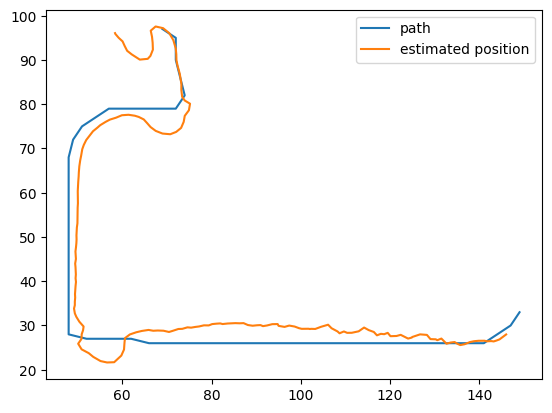

In [18]:
#https://medium.com/@shahinrostami/jupyter-notebook-and-updating-plots-f1ec4cdc354b
fig = plt.figure()
ax = fig.add_subplot(111)

# Main script to establish connection and start movement
try:
    print("Connecting to Thytanic...")
    thytanic.establish_connection()
    print("Connection established!")
    # Get the initial states of the robot from camera, with no velocity
    _, thymiopos, initial_angle = get_current_state(    cam=cam,
    obstacle_range=[np.array([0, 150, 25]), np.array([30, 220, 100])],
    target_range=[np.array([0, 30, 235]), np.array([255, 130, 256])],
    th_front_range=[np.array([0, 160, 250]), np.array([15, 250, 256])],
    th_back_range=[np.array([16, 130, 150]), np.array([35, 250, 249])],)
    
    # Set the robot to GLOBAL_MOVEMENT state to follow the path
    thytanic.robot_state = ThytanicState.GLOBAL_MOVEMENT
    print("Thytanic state set to GLOBAL_MOVEMENT.")
    print("initital_angle:", initial_angle)
    thytanic.x_est = np.array([thymiopos[1], 0, thymiopos[0], 0,initial_angle,0]) #position, velocity (x,y,angle)
    thytanic.P_est = np.eye(6) # initialized with large variance values but it doesn't have a big impact since P_est converges quickly to a finite value independent of the initial value
    thytanic.goal_idx = 0 # target the first point of path
    x_estimated = [] # to store the values of estimated positions
    
    # Downsample the path to reduce the number of points (1/5 points)
    path = path[::5]
    path = path[2:] #skip the first point to avoid the current position
    # Flip the x and y coordinates
    path = np.array([[p[1], p[0]] for p in path])

    # Start the robot movement loop
    while True:
        acc = thytanic.read_accelerometer()
        if(acc[2] > 28):    # usually around 20 because of gravity, when kidnapped it increases (a large threshold is used to avoid false positives from when the robot is turning)
            thytanic.set_wheel_speed(0, 0)
            time.sleep(10)
            #Recomputing new position and path
            img, thymiopos, initital_angle = get_current_state(cam=cam,
                obstacle_range=obstacle_range,
                target_range=target_range,
                th_front_range=th_front_range,
                th_back_range=th_back_range,
            )
            endsize = [120, 160]

            #this line generates the original enposition, thymio position, and the obstacle channel
            thymiopos, endpos, obstacleimage = downsamplingprep(img, endsize, 1, 1)

            #this line turns obstacleimage into its downsampled version with enlarged obstacles
            preppedimage = downsampling(obstacleimage, endsize, 25, 0.2)
            path, exploredpoints, unexploredpoints = pathfinder(thymiopos, endpos, preppedimage)  

            # Set the robot to GLOBAL_MOVEMENT state
            #print("initital_angle:", initital_angle)
            thytanic.x_est = np.array([thymiopos[1], 0, thymiopos[0], 0,initital_angle,0]) #position, velocity (x,y,angle)
            thytanic.P_est = np.eye(6)
            thytanic.goal_idx = 0
            thytanic.robot_state = ThytanicState.GLOBAL_MOVEMENT
            x_estimated = [] # initialize again

            #new path
            path = path[::5]
            path = path[2:]
            path = np.array([[p[1], p[0]] for p in path])  
            
        # get measured position and orientation from camera
        _, thymiopos, orientation = get_current_state(    cam=cam,
            obstacle_range=obstacle_range,
            target_range=target_range,
            th_front_range=th_front_range,
            th_back_range=th_back_range,
        )
        # apply kalman filter and get the estimated positions thytanic.x_est
        kalman_filter(thytanic, [thymiopos[1], thymiopos[0], orientation])
        x_estimated.append(thytanic.x_est)
        thytanic.goal = path[thytanic.goal_idx] # get the (x,y) coordinates of the goal point
        thytanic.update_robot_state()

        # Print the proximity sensor values
        sensor_values = thytanic.read_proximity_sensors()
        
        ax.cla()
        ax.plot(path[:,0], path[:,1], label='path')
        ax.plot(np.array(x_estimated)[:,0], np.array(x_estimated)[:,2], label='estimated position')
        # Plot the path
        ax.legend()
        ax.set_xlabel('x in pixels')
        ax.set_ylabel('y in pixels')
        display(fig)
        clear_output(wait=True)
        
        if thytanic.goal_idx >= len(path +1): # if the goal reached the last point of the path it stops
            thytanic.robot_state = ThytanicState.STOP
            thytanic.update_robot_state()
            print("Goal reached!")
            break 

except KeyboardInterrupt:
    # Handle interruption and stop the robot safely
    print("\nStopping the Thytanic...")
    thytanic.disconnect()
    print("Thytanic stopped and disconnected.")

finally:
    print("Session ended.")
    thytanic.disconnect()

## 9. Conclusion